Total Tokens Generated: 732,988
Token Distribution:
count        42
mean     17,452
std       7,540
min           0
25%      14,533
50%      16,347
75%      20,575
max      36,594
Name: total_tokens, dtype: object

Prompt Tokens Distribution:
count        42
mean     16,357
std       7,328
min           0
25%      13,280
50%      15,100
75%      19,094
max      35,656
Name: prompt_tokens, dtype: object

Completion Tokens Distribution:
count       42
mean     1,095
std        592
min          0
25%        902
50%        953
75%      1,162
max      2,885
Name: completion_tokens, dtype: object


/var/folders/vk/lr3bg18d699bvkgxqntwqv9r0000gn/T/ipykernel_65381/504086242.py:192: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  token_bar = sns.barplot(


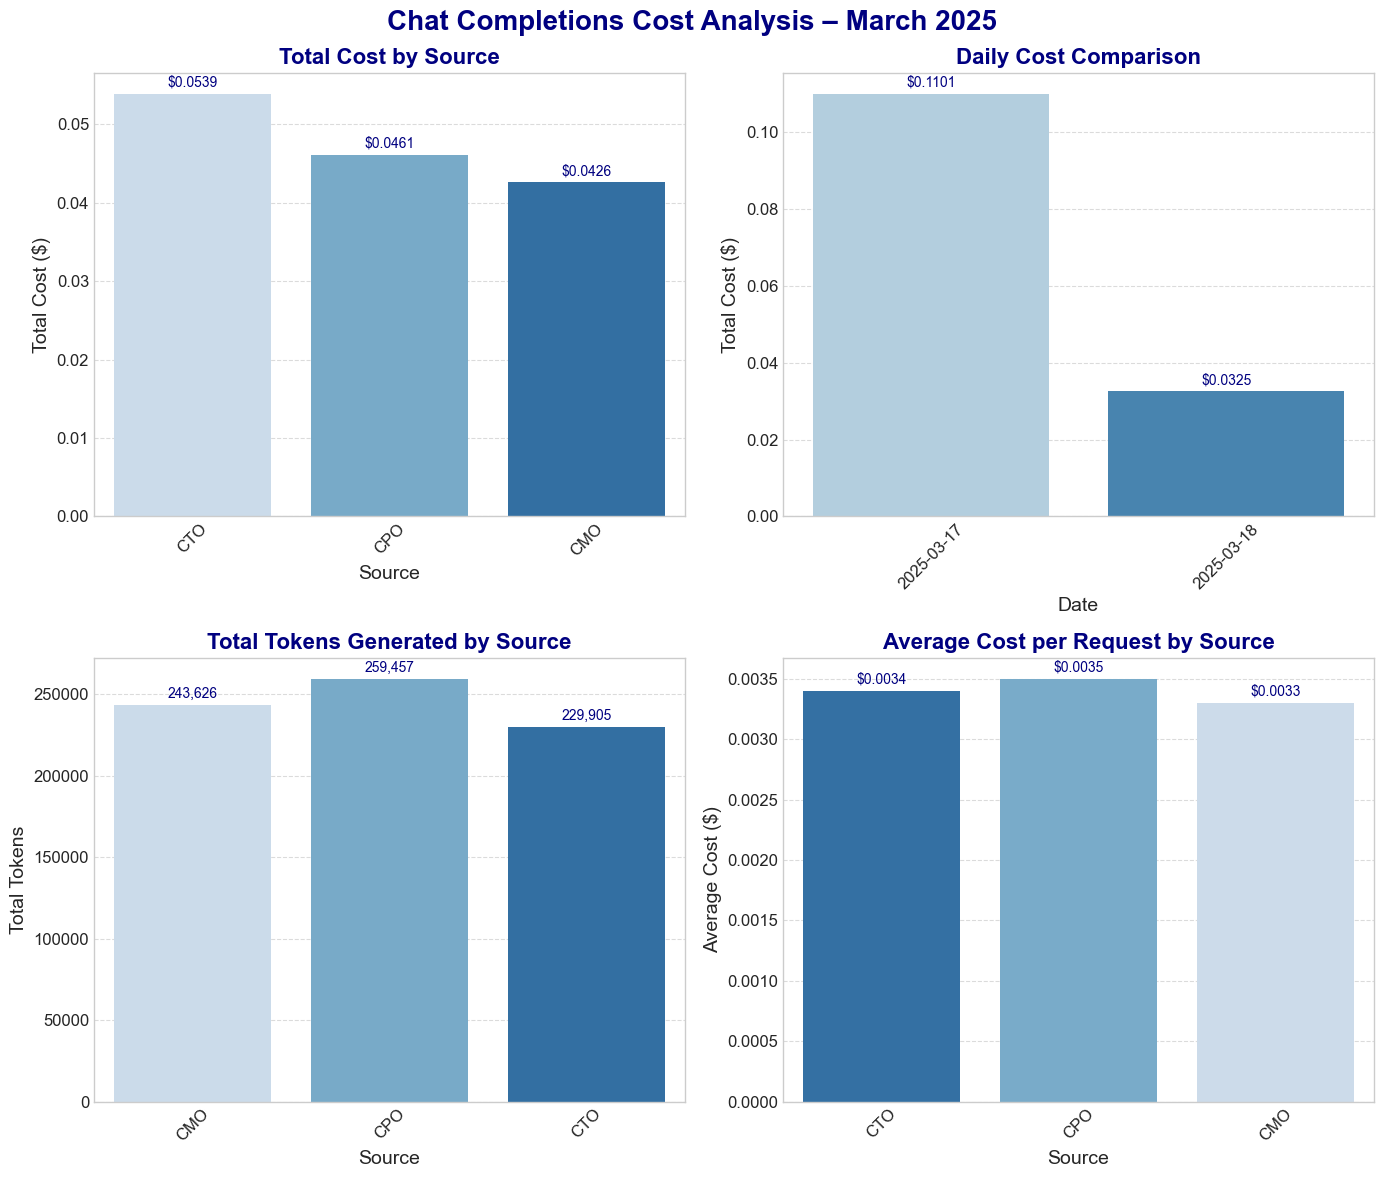

Request and Response Size Statistics:


,Request Size (chars),Response Size (chars),Duration (seconds),Cost ($)
Average,75219.0952,5977.2857,30.7214,0.0034
Minimum,44998.0000,48.0000,2.1728,0.0000
Maximum,155674.0000,14778.0000,271.8249,0.0090
Median,65801.0000,5603.0000,14.6567,0.0030



Total Cost: $0.1426
Total Requests: 42
Average Cost Per Request: $0.0034

Average Cost per Response Character: $0.000001

Cost Metrics by Source:
             Total_Requests  Total_Cost  Average_Cost  Minimum_Cost  \
source_name                                                           
CMO                      13      0.0426        0.0033        0.0023   
CPO                      13      0.0461        0.0035        0.0024   
CTO                      16      0.0539        0.0034        0.0000   

             Maximum_Cost  
source_name                
CMO                0.0058  
CPO                0.0059  
CTO                0.0090  


,Total Tokens,Prompt Tokens,Completion Tokens
count,42,42,42
mean,"17,452","16,357","1,095"
std,"7,540","7,328",592
min,0,0,0
25%,"14,533","13,280",902
50%,"16,347","15,100",953
75%,"20,575","19,094","1,162"
max,"36,594","35,656","2,885"


,total_tokens_mean,total_tokens_sum,total_tokens_min,total_tokens_max,prompt_tokens_mean,prompt_tokens_sum,prompt_tokens_min,prompt_tokens_max,completion_tokens_mean,completion_tokens_sum,completion_tokens_min,completion_tokens_max
source_name,,,,,,,,,,,,
CMO,"18,740","243,626","12,524","35,670","17,703","230,134","11,615","34,591","1,038","13,492",266,"2,097"
CPO,"19,958","259,457","13,449","36,594","18,726","243,444","12,510","35,656","1,232","16,013",810,"2,885"
CTO,"14,369","229,905",0,"34,557","13,339","213,427",0,"33,394","1,030","16,478",0,"2,877"


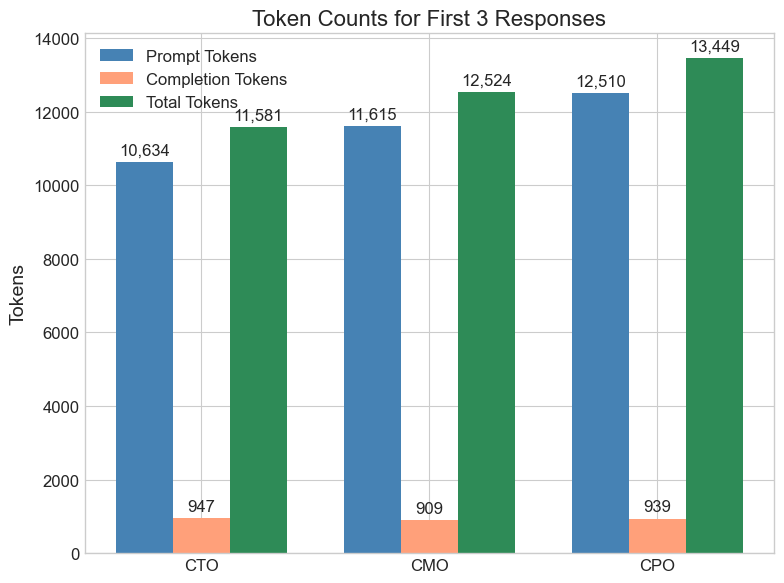

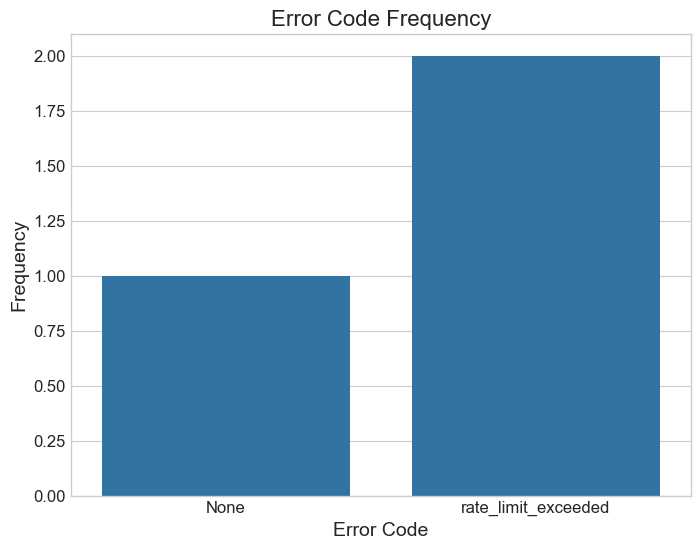

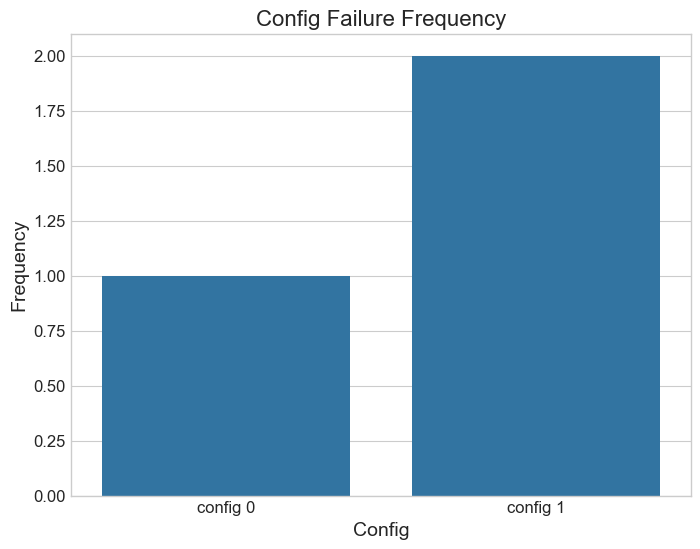

In [6]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json

# Set up plotting style and parameters
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 10)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14

# Connect to the SQLite database and load the data
conn = sqlite3.connect('Logsfinal.db')
df = pd.read_sql_query('SELECT * FROM chat_completions', conn)
conn.close()

# Convert time columns and calculate duration and date
df['start_time'] = pd.to_datetime(df['start_time'])
df['end_time'] = pd.to_datetime(df['end_time'])
df['duration'] = (df['end_time'] - df['start_time']).dt.total_seconds()
df['date'] = df['start_time'].dt.date

# Compute sizes of request and response
df['request_size'] = df['request'].str.len()
df['response_size'] = df['response'].str.len()

# Replace source names for consistency
df['source_name'] = df['source_name'].replace({
    'cto': 'CTO',
    'cmo': 'CMO',
    'cpo': 'CPO'
})

# --- Total Tokens Extraction ---
def extract_total_tokens(response_str):
    try:
        response_json = json.loads(response_str)
        return int(response_json.get('usage', {}).get('total_tokens', 0))
    except (json.JSONDecodeError, TypeError):
        return 0

df['total_tokens'] = df['response'].apply(extract_total_tokens)

# --- Prompt and Completion Tokens Extraction ---
def extract_usage_tokens(response_str):
    try:
        response_json = json.loads(response_str)
        usage = response_json.get('usage', {})
        prompt_tokens = int(usage.get('prompt_tokens', 0))
        completion_tokens = int(usage.get('completion_tokens', 0))
        return prompt_tokens, completion_tokens
    except (json.JSONDecodeError, TypeError):
        return 0, 0

df[['prompt_tokens', 'completion_tokens']] = df['response'].apply(
    lambda s: pd.Series(extract_usage_tokens(s))
)

# Print token statistics with better formatting
total_tokens_generated = df['total_tokens'].sum()
print(f"Total Tokens Generated: {total_tokens_generated:,}")
print("Token Distribution:")
print(df['total_tokens'].describe().apply(lambda x: f"{x:,.0f}"))

print("\nPrompt Tokens Distribution:")
print(df['prompt_tokens'].describe().apply(lambda x: f"{x:,.0f}"))

print("\nCompletion Tokens Distribution:")
print(df['completion_tokens'].describe().apply(lambda x: f"{x:,.0f}"))

# --- Size Statistics ---
size_stats = pd.DataFrame({
    'Request Size (chars)': [
        df['request_size'].mean(),
        df['request_size'].min(),
        df['request_size'].max(),
        df['request_size'].median()
    ],
    'Response Size (chars)': [
        df['response_size'].mean(),
        df['response_size'].min(),
        df['response_size'].max(),
        df['response_size'].median()
    ],
    'Duration (seconds)': [
        df['duration'].mean(),
        df['duration'].min(),
        df['duration'].max(),
        df['duration'].median()
    ],
    'Cost ($)': [
        df['cost'].mean(),
        df['cost'].min(),
        df['cost'].max(),
        df['cost'].median()
    ]
}, index=['Average', 'Minimum', 'Maximum', 'Median']).round(4)

# --- Source Statistics ---
source_stats = df.groupby('source_name').agg({
    'cost': ['count', 'mean', 'sum', 'min', 'max'],
    'duration': ['mean'],
    'request_size': ['mean', 'max'],
    'response_size': ['mean', 'max']
}).round(4)
source_stats.columns = [
    'Number of Requests', 'Average Cost', 'Total Cost', 'Minimum Cost', 'Maximum Cost',
    'Average Duration (s)', 'Average Request Size', 'Max Request Size',
    'Average Response Size', 'Max Response Size'
]
source_stats = source_stats.sort_values('Total Cost', ascending=False)
total_cost = df['cost'].sum()

# --- Plotting (2x2 Grid) ---
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
plt.subplots_adjust(hspace=0.3, wspace=0.3)

# Plot 1: Total Cost by Source
blue_palette = sns.color_palette("Blues", len(source_stats))
ax1 = axes[0, 0]
tmp_source = source_stats.reset_index().rename(columns={'index': 'source_name'})
total_cost_bars = sns.barplot(
    data=tmp_source,
    x='source_name',
    y='Total Cost',
    hue='source_name',
    dodge=False,
    legend=False,
    palette=blue_palette,
    ax=ax1
)
ax1.set_title('Total Cost by Source', fontweight='bold', color='navy')
ax1.set_xlabel('Source')
ax1.set_ylabel('Total Cost ($)')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(axis='y', linestyle='--', alpha=0.7)
max_cost = source_stats['Total Cost'].max()
offset = 0.01 * max_cost
for bar in total_cost_bars.patches:
    height = bar.get_height()
    ax1.text(
        bar.get_x() + bar.get_width() / 2.0,
        height + offset,
        f'${height:,.4f}',
        ha='center',
        va='bottom',
        fontsize=10,
        color='navy'
    )

# Plot 2: Daily Cost Comparison
ax2 = axes[0, 1]
daily_costs = df.groupby('date')['cost'].sum().reset_index()
daily_costs['date'] = daily_costs['date'].astype(str)
daily_palette = sns.color_palette("Blues", len(daily_costs))
daily_cost_bars = sns.barplot(
    data=daily_costs,
    x='date',
    y='cost',
    hue='date',
    dodge=False,
    legend=False,
    palette=daily_palette,
    ax=ax2
)
ax2.set_title('Daily Cost Comparison', fontweight='bold', color='navy')
ax2.set_xlabel('Date')
ax2.set_ylabel('Total Cost ($)')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(axis='y', linestyle='--', alpha=0.7)
max_daily = daily_costs['cost'].max()
offset_daily = 0.01 * max_daily
for bar in daily_cost_bars.patches:
    height = bar.get_height()
    ax2.text(
        bar.get_x() + bar.get_width() / 2.0,
        height + offset_daily,
        f'${height:,.4f}',
        ha='center',
        va='bottom',
        fontsize=10,
        color='navy'
    )

# Plot 3: Total Tokens Generated by Source
ax3 = axes[1, 0]
tokens_by_source = df.groupby('source_name')['total_tokens'].sum().reset_index()
token_palette = sns.color_palette("Blues", len(tokens_by_source))
token_bar = sns.barplot(
    data=tokens_by_source,
    x='source_name',
    y='total_tokens',
    palette=token_palette,
    ax=ax3
)
ax3.set_title('Total Tokens Generated by Source', fontweight='bold', color='navy')
ax3.set_xlabel('Source')
ax3.set_ylabel('Total Tokens')
ax3.tick_params(axis='x', rotation=45)
ax3.grid(axis='y', linestyle='--', alpha=0.7)
max_tokens = tokens_by_source['total_tokens'].max()
offset_tokens = 0.01 * max_tokens
for bar in token_bar.patches:
    height = bar.get_height()
    ax3.text(
        bar.get_x() + bar.get_width() / 2.0,
        height + offset_tokens,
        f'{int(height):,}',
        ha='center',
        va='bottom',
        fontsize=10,
        color='navy'
    )

# Plot 4: Average Cost per Request by Source
ax4 = axes[1, 1]
avg_palette = sns.color_palette("Blues_r", len(source_stats))
avg_cost_bars = sns.barplot(
    data=tmp_source,
    x='source_name',
    y='Average Cost',
    hue='source_name',
    dodge=False,
    legend=False,
    palette=avg_palette,
    ax=ax4
)
ax4.set_title('Average Cost per Request by Source', fontweight='bold', color='navy')
ax4.set_xlabel('Source')
ax4.set_ylabel('Average Cost ($)')
ax4.tick_params(axis='x', rotation=45)
ax4.grid(axis='y', linestyle='--', alpha=0.7)
max_avg = source_stats['Average Cost'].max()
offset_avg = 0.01 * max_avg
for bar in avg_cost_bars.patches:
    height = bar.get_height()
    ax4.text(
        bar.get_x() + bar.get_width() / 2.0,
        height + offset_avg,
        f'${height:,.4f}',
        ha='center',
        va='bottom',
        fontsize=10,
        color='navy'
    )

plt.subplots_adjust(top=0.88)
plt.suptitle('Chat Completions Cost Analysis – March 2025',
             fontsize=20, fontweight='bold', color='navy')
fig.tight_layout()
plt.show()

# --- Display Size Statistics Table ---
print("Request and Response Size Statistics:")
display(size_stats)

print(f"\nTotal Cost: ${total_cost:,.4f}")
print(f"Total Requests: {len(df):,}")
print(f"Average Cost Per Request: ${df['cost'].mean():,.4f}")

df['cost_per_response_char'] = df['cost'] / df['response_size']
df['cost_per_response_char'] = df['cost_per_response_char'].replace(
    [np.inf, -np.inf, np.nan], 0
)
print(f"\nAverage Cost per Response Character: ${df['cost_per_response_char'].mean():,.6f}")

costs_by_source = df.groupby('source_name')['cost'].agg(
    Total_Requests='count',
    Total_Cost='sum',
    Average_Cost='mean',
    Minimum_Cost='min',
    Maximum_Cost='max'
).round(4)
print("\nCost Metrics by Source:")
print(costs_by_source)

# ---------------------------------------------------
# Overall Token Statistics Table with Pandas Styler
# ---------------------------------------------------
overall_token_stats = pd.DataFrame({
    'Total Tokens': df['total_tokens'].describe(),
    'Prompt Tokens': df['prompt_tokens'].describe(),
    'Completion Tokens': df['completion_tokens'].describe()
})

overall_token_stats_styled = (
    overall_token_stats.style
    .set_caption("Overall Token Statistics")
    .format("{:,.0f}", subset=["Total Tokens", "Prompt Tokens", "Completion Tokens"])
    .set_table_styles([
        {'selector': 'caption', 'props': [('font-weight', 'bold'), ('font-size', '16px')]},
        {'selector': 'th', 'props': [('text-align', 'center'), ('font-weight', 'bold')]},
        {'selector': 'td', 'props': [('text-align', 'center')]}
    ])
)
display(overall_token_stats_styled)

# ---------------------------------------------------
# Token Statistics by Source Table with Pandas Styler
# ---------------------------------------------------
token_stats_by_source = df.groupby('source_name').agg({
    'total_tokens': ['mean', 'sum', 'min', 'max'],
    'prompt_tokens': ['mean', 'sum', 'min', 'max'],
    'completion_tokens': ['mean', 'sum', 'min', 'max']
})

# Flatten the multi-index columns
token_stats_by_source.columns = [
    '_'.join(col).strip() for col in token_stats_by_source.columns.values
]

token_stats_by_source_styled = (
    token_stats_by_source.style
    .set_caption("Token Statistics by Source")
    .format("{:,.0f}")
    .set_table_styles([
        {'selector': 'caption', 'props': [('font-weight', 'bold'), ('font-size', '16px')]},
        {'selector': 'th', 'props': [('text-align', 'center'), ('font-weight', 'bold')]},
        {'selector': 'td', 'props': [('text-align', 'center')]}
    ])
)
display(token_stats_by_source_styled)

# ---------------------------------------------------
# Plot for First 3 Responses Token Breakdown
# ---------------------------------------------------
# Extract the first three responses and select relevant columns
subset = df.iloc[0:3][['source_name', 'prompt_tokens', 'completion_tokens', 'total_tokens']].copy()
# Use the source names as the index labels
subset.index = [row['source_name'] for _, row in subset.iterrows()]

# Set up positions for a grouped bar chart (3 groups, each with 3 bars)
x = np.arange(len(subset))
width = 0.25  # width of each bar

fig, ax = plt.subplots(figsize=(8, 6))
rects1 = ax.bar(x - width, subset['prompt_tokens'], width, label='Prompt Tokens', color='steelblue')
rects2 = ax.bar(x, subset['completion_tokens'], width, label='Completion Tokens', color='lightsalmon')
rects3 = ax.bar(x + width, subset['total_tokens'], width, label='Total Tokens', color='seagreen')

# Labeling and formatting the plot
ax.set_xticks(x)
ax.set_xticklabels(subset.index)
ax.set_ylabel('Tokens')
ax.set_title('Token Counts for First 3 Responses')
ax.legend()

# Function to annotate bars with token counts
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{int(height):,}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

plt.tight_layout()
plt.show()

try:
    error_data = []
    for response_str in df['response']:
        if isinstance(response_str, str):
            if '{"response": "error_' in response_str:
                if "error_code:None" in response_str:
                    error_data.append({"error_code": "None", "config": "config 0"})
                elif "error_code:rate_limit_exceeded" in response_str:
                    error_data.append({"error_code": "rate_limit_exceeded", "config": "config 1"})

    error_df = pd.DataFrame(error_data)

    if not error_df.empty:
        # Error Code Frequency
        plt.figure(figsize=(8, 6))
        sns.countplot(data=error_df, x="error_code")
        plt.title("Error Code Frequency")
        plt.xlabel("Error Code")
        plt.ylabel("Frequency")
        plt.show()
    else:
        print("\nNo relevant error data found.")

except Exception as e:
    print(f"\nError processing error data: {e}")